In [1]:
import os
from dotenv import load_dotenv

from pathlib import Path
import sys

PATH_PROJECT_ROOT_DIR = Path(os.getcwd()).resolve().parent
PATH_SRC_DIR = os.path.join(PATH_PROJECT_ROOT_DIR, "src/")

sys.path.append(str(PATH_SRC_DIR))

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from wordcloud import WordCloud

## ML modules
# Hugging face imports
from huggingface_hub import login
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, pipeline,Trainer, TrainingArguments,AutoConfig)
from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


# Utils
from pipeline_scripts.utils import clean_text


In [3]:
input_tw = pd.read_parquet("data/train-00000-of-00001.parquet")

# Quick EDA
print("Shape:", input_tw.shape)
print("\nColumns:", input_tw.columns.tolist())
print("\nMissing values:\n", input_tw.isnull().sum())
print("\nSentiment value counts:\n", input_tw['sentiment'].value_counts())
print("\nTweet length stats:\n", input_tw['tweet'].apply(len).describe())
input_tw.head(5)

Shape: (38091, 3)

Columns: ['tweet', 'sentiment', 'url']

Missing values:
 tweet        0
sentiment    0
url          0
dtype: int64

Sentiment value counts:
 sentiment
1    17368
0    12181
2     8542
Name: count, dtype: int64

Tweet length stats:
 count    38091.000000
mean        95.323751
std         72.693280
min          1.000000
25%         55.000000
50%         84.000000
75%        131.000000
max       4229.000000
Name: tweet, dtype: float64


,tweet,sentiment,url
0,$BYND - JPMorgan reels in expectations on Beyo...,2,https://huggingface.co/datasets/zeroshot/twitt...
1,$CCL $RCL - Nomura points to bookings weakness...,2,https://huggingface.co/datasets/zeroshot/twitt...
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",2,https://huggingface.co/datasets/zeroshot/twitt...
3,$ESS: BTIG Research cuts to Neutral https://t....,2,https://huggingface.co/datasets/zeroshot/twitt...
4,$FNKO - Funko slides after Piper Jaffray PT cu...,2,https://huggingface.co/datasets/zeroshot/twitt...


/tmp/ipykernel_282321/1315524807.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax_box.boxplot(data, patch_artist=True, labels=labels, showmeans=True, meanline=False)


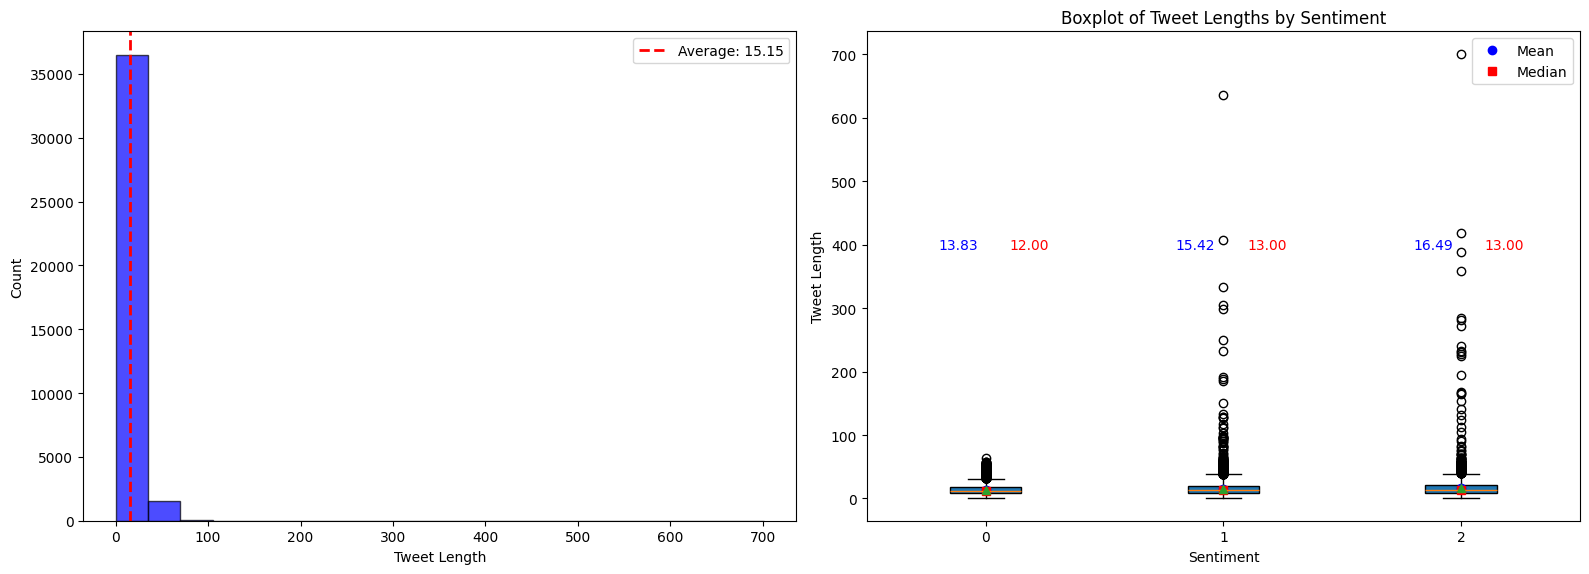

In [4]:

# Calculate tweet lengths
input_tw['tweet_length'] = input_tw['tweet'].str.split().str.len()
text_lengths = input_tw['tweet_length']
average_length = np.mean(text_lengths)

# Prepare data grouped by sentiment
grouped = input_tw.groupby('sentiment')['tweet_length']
data = [grouped.get_group(sent) for sent in grouped.groups]
labels = list(grouped.groups.keys())

# Create subplot: histogram + customized boxplot
fig, (ax_hist, ax_box) = plt.subplots(1, 2, figsize=(16, 6))

# Histogram
ax_hist.hist(text_lengths, bins=20, color="blue", edgecolor="black", alpha=0.7)
ax_hist.axvline(average_length, color='red', linestyle='dashed', linewidth=2, label=f'Average: {average_length:.2f}')
ax_hist.set_xlabel('Tweet Length')
ax_hist.set_ylabel('Count')
ax_hist.legend()

# Boxplot with custom mean and median
box = ax_box.boxplot(data, patch_artist=True, labels=labels, showmeans=True, meanline=False)

# Add mean and median markers and annotate their values
for i, group_data in enumerate(data, start=1):
    mean_val = np.mean(group_data)
    median_val = np.median(group_data)
    
    # Plot markers
    ax_box.plot(i, mean_val, 'o', color='blue', label='Mean' if i == 1 else "")
    ax_box.plot(i, median_val, 's', color='red', label='Median' if i == 1 else "")
    
    # Add text annotations
    ax_box.text(i - 0.2, 400, f'{mean_val:.2f}', color='blue', va='center')
    ax_box.text(i + 0.1, 400, f'{median_val:.2f}', color='red', va='center')

# Avoid duplicate legend entries
handles, labels = ax_box.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax_box.legend(by_label.values(), by_label.keys())

ax_box.set_title('Boxplot of Tweet Lengths by Sentiment')
ax_box.set_xlabel('Sentiment')
ax_box.set_ylabel('Tweet Length')
fig.suptitle('')  # Remove pandas-style title

plt.tight_layout()
plt.show()


In [5]:
df_tw = input_tw[['tweet', 'sentiment']].rename(columns={'sentiment': 'label'})
df_tw['tweet'] = df_tw['tweet'].apply(clean_text)

(np.float64(-0.5), np.float64(399.5), np.float64(199.5), np.float64(-0.5))

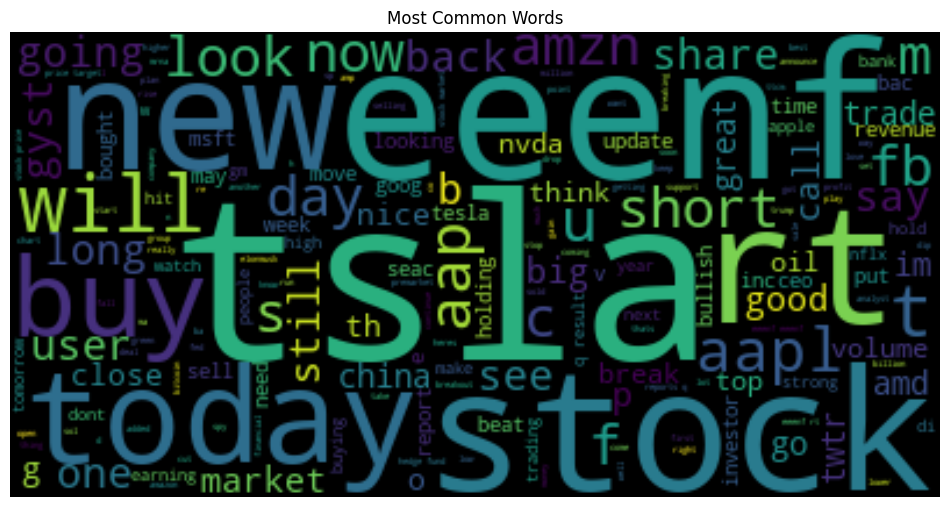

In [6]:
text_raw = df_tw['tweet'].to_string()
wordcloud = WordCloud().generate(text_raw)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud,interpolation='bilinear')
plt.title('Most Common Words')
plt.axis("off")

In [7]:
# Point to your internal certificate
os.environ["REQUESTS_CA_BUNDLE"] = "/etc/pki/tls/certs/sanofi-ca.crt" ################# DELETE ###############
token = os.getenv("TOKEN_HF")
if not token:
    raise ValueError("TOKEN_HF environment variable is not set. Please set it in your .env file.")
login(token=token)


In [16]:
models = [
    "ProsusAI/finbert",
    "StephanAkkerman/FinTwitBERT-sentiment",
    # "yiyanghkust/finbert-tone"
]  


# Different models have different label mappings, so we need to handle them accordingly
for model_id in models:    
    config = AutoConfig.from_pretrained(model_id)
    print(model_id, config.label2id)


ProsusAI/finbert {'positive': 0, 'negative': 1, 'neutral': 2}
StephanAkkerman/FinTwitBERT-sentiment {'BEARISH': 2, 'BULLISH': 1, 'NEUTRAL': 0}


In [13]:
import pandas as pd

# Simulated tweets
tweets = [
    "Apple's earnings report just beat all expectations! 🚀 #stocks",
    "The Fed raising rates again? This can't be good for growth...",
    "Crypto market is showing signs of recovery after months of decline.",
    "Bought Tesla at $620 last month. Today it's $790. Love this game!",
    "My portfolio is bleeding. Every red day makes me question my life choices.",
    "Netflix subscribers dropped for the first time in years. Not looking good.",
    "Finally hit my savings goal for the year! Budgeting pays off.",
    "The housing market is cooling down faster than expected. Is a crash coming?",
    "Inflation numbers are slightly lower than last month. Some relief at least.",
    "Just lost 15% of my investments this quarter. Brutal.",
    "Why is everyone bullish on tech again? Didn't we learn anything in 2022?",
    "Dividend from JPMorgan just landed. Love passive income!",
    "Gold is up as markets grow uncertain. Old school hedge still works.",
    "Missed the Nvidia rally. My FOMO is real right now.",
    "Oil prices dipped again today. Could mean lower gas prices soon.",
    "Got approved for my first mortgage. Excited but nervous!",
    "Layoffs coming again in the fintech space. What a tough year.",
    "Finally paid off all my student loans! Debt-free at last.",
    "Not sure what to make of this market. Holding cash for now.",
    "That earnings call from Amazon was a mess. Stock tanked immediately."
]

# Corresponding sentiments
sentiments = [
    "positive", "negative", "neutral", "positive", "negative",
    "negative", "positive", "negative", "neutral", "negative",
    "neutral", "positive", "positive", "negative", "positive",
    "positive", "negative", "positive", "neutral", "negative"
]

# Create the DataFrame
df_tweets = pd.DataFrame({
    "tweet": tweets,
    "sentiment": sentiments
})

# Define sentiment mapping
sentiment_map = {'negative': 0, 'positive': 1, 'neutral': 2}

# Apply the mapping
df_tweets['sentiment'] = df_tweets['sentiment'].map(sentiment_map)

# Display result
print(df_tweets)


                                                tweet  sentiment
0   Apple's earnings report just beat all expectat...          1
1   The Fed raising rates again? This can't be goo...          0
2   Crypto market is showing signs of recovery aft...          2
3   Bought Tesla at $620 last month. Today it's $7...          1
4   My portfolio is bleeding. Every red day makes ...          0
5   Netflix subscribers dropped for the first time...          0
6   Finally hit my savings goal for the year! Budg...          1
7   The housing market is cooling down faster than...          0
8   Inflation numbers are slightly lower than last...          2
9   Just lost 15% of my investments this quarter. ...          0
10  Why is everyone bullish on tech again? Didn't ...          2
11  Dividend from JPMorgan just landed. Love passi...          1
12  Gold is up as markets grow uncertain. Old scho...          1
13  Missed the Nvidia rally. My FOMO is real right...          0
14  Oil prices dipped aga

In [23]:
print(sampled_df['tweet'].head(20))

0                      Live Ventures reports FY results
1     Aurora Property Buy Write Income Trust : NTA E...
2     Hong Kong Airlines to cut 400 jobs, ask employ...
3     Ford risks Mustang fan backlash with SUV: They...
4     Women-led businesses, which make up just 20% o...
5     Elon basically said stop buying $tsla calls an...
6     So glad I sold pay around 31,I was tempted to ...
7     Google launched its cloud gaming service Stadi...
8     WFC BAC C Your dark horses for the week. Will ...
9     The U.S. should declare a 3-month break for no...
10    $AMZN this is now in the money, 20 minutes. Ab...
11    @Michael36576048 @gmwagmieth @GM You are loser...
12                 all on an upward trend this month.\n
13    Elon Musk is poor. \r\n\r\nHas a bunch of over...
14    NKD  - great start to 2013, up 54%, 2nd best p...
15    Amazon's Ring received more than 22,000 police...
16    Nice to see NKD giving the bears/shorts their ...
17    Aurora sets early conversion price for con

In [20]:

sampled_df = input_tw.sample(100, random_state=32).reset_index(drop=True)

sentiment_map = {'negative': 0, 'positive': 1, 'neutral': 2}

for model_name in models:
    
    # Set up the model and tokenizer
    # Map the label properly
    cfg = AutoConfig.from_pretrained(model_name)
    cfg.id2label   = {0: "negative", 1: "positive", 2: "neutral"}
    cfg.label2id   = {v: k for k, v in cfg.id2label.items()}
    cfg.num_labels = 3

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model     = AutoModelForSequenceClassification.from_pretrained(
                    model_name,
                    config=cfg
                )

    clf = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

    # Run the model
    res = pd.DataFrame(clf(sampled_df['tweet'].tolist(), truncation=True))

    res['label_norm'] = res['label'].str.lower()
    res['predicted']  = res['label_norm'].map(sentiment_map)

    # Compute the accuracy and the confusion matrix
    true_nums = sampled_df['sentiment']
    acc       = (res['predicted'] == true_nums).mean()

    cm = pd.crosstab(
        true_nums.map({0:"negative",1:"positive",2:"neutral"}),
        res['label_norm'],
        rownames=['Actual'], colnames=['Predicted'], dropna=False
    )

    print(f"\n=== {model_name} ===")
    print("Confusion matrix:\n", cm)
    print(f"Accuracy: {acc:.2%}")


Device set to use cpu



=== ProsusAI/finbert ===
Confusion matrix:
 Predicted  negative  neutral  positive
Actual                                
negative          3       30         3
neutral           0       10        11
positive          9       29         5
Accuracy: 18.00%


Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.



=== StephanAkkerman/FinTwitBERT-sentiment ===
Confusion matrix:
 Predicted  negative  neutral  positive
Actual                                
negative         29        5         2
neutral           0       20         1
positive          1        7        35
Accuracy: 84.00%


In [19]:
print(res)

       label     score label_norm  predicted
0   positive  0.998011   positive          1
1    neutral  0.995464    neutral          2
2   negative  0.906502   negative          0
3   positive  0.816210   positive          1
4    neutral  0.999951    neutral          2
5    neutral  0.999093    neutral          2
6   positive  0.899962   positive          1
7    neutral  0.999729    neutral          2
8    neutral  0.539259    neutral          2
9    neutral  0.999956    neutral          2
10   neutral  0.995494    neutral          2
11  positive  0.655045   positive          1
12  positive  0.746085   positive          1
13   neutral  0.999003    neutral          2
14   neutral  0.991265    neutral          2
15   neutral  0.696322    neutral          2
16   neutral  0.999598    neutral          2
17   neutral  0.633929    neutral          2
18   neutral  0.986994    neutral          2
19   neutral  0.999812    neutral          2


In [57]:
# FintweetBERT results
data = {
    "negative": [2467, 57, 237],
    "neutral":  [307, 1994, 448],
    "positive": [441, 145, 3904],
}

index = ["negative", "neutral", "positive"]
df_cm = pd.DataFrame(data, index=index)
df_cm.index.name = "Actual"
df_cm.columns.name = "Predicted"



In [58]:
# 1) True positives (TP) for each class:
tp = np.diag(df_cm)

# 2) False positives: sum of column minus TP
fp = df_cm.sum(axis=0) - tp

# 3) False negatives: sum of row minus TP
fn = df_cm.sum(axis=1) - tp

# 4) Precision and recall per class
precision = tp / (tp + fp)
recall    = tp / (tp + fn)

# 5) F1 per class (handle zero‑division gracefully)
f1 = 2 * precision * recall / (precision + recall)

# 6) Macro‑F1: unweighted mean across classes
macro_f1 = np.nanmean(f1)

print("Per‑class precision:", precision)
print("Per‑class recall:   ", recall)
print("Per‑class F1:       ", f1)
print("Macro‑F1:           ", macro_f1)

Per‑class precision: Predicted
negative    0.893517
neutral     0.725355
positive    0.869488
dtype: float64
Per‑class recall:    Actual
negative    0.767341
neutral     0.908015
positive    0.850730
dtype: float64
Per‑class F1:        Predicted
negative    0.825636
neutral     0.806471
positive    0.860007
dtype: float64
Macro‑F1:            0.8307045561703937


## **FINETUNNING OF THE MODEL (OPTIONAL)**
The accuracy of NLP models heavily depends on the quality and nature of the training data. As a result, model performance can vary significantly if the input data used for prediction differs from the data it was originally trained on. If a pretrained model does not deliver the desired results, it is possible to fine-tune it using a different dataset that better reflects the target use case.

In [ ]:
INPUT_DATAFRAME = input_tw.sample(5000, random_state=50).reset_index(drop=True) # Change

In [ ]:
# 2. Prepare data
df_full = INPUT_DATAFRAME.rename(columns={'tweet':'text', 'sentiment':'label'})
train_df, test_df = train_test_split(
    df_full, test_size=0.2, random_state=1, stratify=df_full['label']
)
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'test':  Dataset.from_pandas(test_df.reset_index(drop=True))
})

# 3. Tokenizer + preprocessing
model_name = "StephanAkkerman/FinTwitBERT-sentiment"
tokenizer  = AutoTokenizer.from_pretrained(model_name)
def model_init():
    cfg = AutoConfig.from_pretrained(model_name)
    cfg.id2label = {0: "negative", 1: "positive", 2: "neutral"}  # adjust if needed
    cfg.label2id = {v: k for k, v in cfg.id2label.items()}
    cfg.num_labels = 3
    return AutoModelForSequenceClassification.from_pretrained(model_name, config=cfg)

def preprocess(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=128)

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column('label','labels')
dataset = dataset.remove_columns(['text'])
dataset.set_format('torch')

# 4. Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    return {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1}

# 5. Model‑init function for hyperparameter search
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

# 6. Base training args
base_args = TrainingArguments(
    output_dir='./nlp_models/optuna_fintwitbert',
    eval_strategy='epoch',
    save_strategy='epoch',
    disable_tqdm=True,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    seed=1,
)

trainer = Trainer(
    model_init=model_init,
    args=base_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 7. Define the search space
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8,16,32]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.3),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 2, 5),
        "warmup_steps": trial.suggest_categorical("warmup_steps", [0, 100, 200]),
    }

# 8. Run hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    hp_space=hp_space_optuna,
    n_trials=3,                  # number of trials
    compute_objective=lambda metrics: metrics["eval_f1"]
)

print("Best run:", best_run)
# 10. Train!
trainer.train()

# 11. Evaluate on test set
results = trainer.evaluate()
print(results)

# 12. (Optional) Save your fine‑tuned model
trainer.save_model('./nlp_models/finetuned_fintwitbert')

Map:   0%|          | 0/160 [00:00<?, ? examples/s]

Map:   0%|          | 0/40 [00:00<?, ? examples/s]

/tmp/ipykernel_880902/4079429361.py:52: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[I 2025-07-19 20:48:06,610] A new study created in memory with name: no-name-de19e136-558f-45bc-ae4d-78ca48276b6e
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.33388203382492065, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2349, 'eval_samples_per_second': 17.898, 'eval_steps_per_second': 2.237, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3249876797199249, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2746, 'eval_samples_per_second': 17.586, 'eval_steps_per_second': 2.198, 'epoch': 2.0}
{'train_runtime': 85.7032, 'train_samples_per_second': 3.734, 'train_steps_per_second': 0.117, 'train_loss': 0.41321454048156736, 'epoch': 2.0}


[I 2025-07-19 20:49:33,751] Trial 0 finished with value: 0.853030303030303 and parameters: {'learning_rate': 3.0453656318198958e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.22476203410479345, 'num_train_epochs': 2, 'warmup_steps': 100}. Best is trial 0 with value: 0.853030303030303.
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.2835005819797516, 'eval_accuracy': 0.875, 'eval_precision': 0.888888888888889, 'eval_recall': 0.8288239538239538, 'eval_f1': 0.8518518518518517, 'eval_runtime': 2.3474, 'eval_samples_per_second': 17.04, 'eval_steps_per_second': 2.13, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29445716738700867, 'eval_accuracy': 0.9, 'eval_precision': 0.9466666666666667, 'eval_recall': 0.8446969696969697, 'eval_f1': 0.8782183999575303, 'eval_runtime': 2.3609, 'eval_samples_per_second': 16.943, 'eval_steps_per_second': 2.118, 'epoch': 2.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.29624199867248535, 'eval_accuracy': 0.9, 'eval_precision': 0.9466666666666667, 'eval_recall': 0.8446969696969697, 'eval_f1': 0.8782183999575303, 'eval_runtime': 2.2566, 'eval_samples_per_second': 17.725, 'eval_steps_per_second': 2.216, 'epoch': 3.0}
{'train_runtime': 134.4783, 'train_samples_per_second': 3.569, 'train_steps_per_second': 0.223, 'train_loss': 0.3144891103108724, 'epoch': 3.0}


[I 2025-07-19 20:51:49,690] Trial 1 finished with value: 0.8782183999575303 and parameters: {'learning_rate': 2.0249253515492823e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.04522440929510718, 'num_train_epochs': 3, 'warmup_steps': 0}. Best is trial 1 with value: 0.8782183999575303.
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2756, 'eval_samples_per_second': 17.578, 'eval_steps_per_second': 2.197, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3335334360599518, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.163, 'eval_samples_per_second': 18.492, 'eval_steps_per_second': 2.312, 'epoch': 2.0}
{'train_runtime': 83.2541, 'train_samples_per_second': 3.844, 'train_steps_per_second': 0.12, 'train_loss': 0.4168869495391846, 'epoch': 2.0}


[I 2025-07-19 20:53:14,693] Trial 2 finished with value: 0.853030303030303 and parameters: {'learning_rate': 1.5839636925557163e-06, 'per_device_train_batch_size': 32, 'weight_decay': 0.05197101902009847, 'num_train_epochs': 2, 'warmup_steps': 200}. Best is trial 1 with value: 0.8782183999575303.


Best run: BestRun(run_id='1', objective=0.8782183999575303, hyperparameters={'learning_rate': 2.0249253515492823e-06, 'per_device_train_batch_size': 16, 'weight_decay': 0.04522440929510718, 'num_train_epochs': 3, 'warmup_steps': 0}, run_summary=None)


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.2146, 'eval_samples_per_second': 18.062, 'eval_steps_per_second': 2.258, 'epoch': 1.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3335334360599518, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.1713, 'eval_samples_per_second': 18.422, 'eval_steps_per_second': 2.303, 'epoch': 2.0}
{'train_runtime': 84.2067, 'train_samples_per_second': 3.8, 'train_steps_per_second': 0.119, 'train_loss': 0.4168869495391846, 'epoch': 2.0}


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.3326, 'eval_samples_per_second': 17.148, 'eval_steps_per_second': 2.144, 'epoch': 2.0}
{'eval_loss': 0.3360397517681122, 'eval_accuracy': 0.875, 'eval_precision': 0.8731884057971014, 'eval_recall': 0.8401875901875901, 'eval_f1': 0.853030303030303, 'eval_runtime': 2.3326, 'eval_samples_per_second': 17.148, 'eval_steps_per_second': 2.144, 'epoch': 2.0}


In [26]:
sampled_df_final = input_tw.sample(10000, random_state=50).reset_index(drop=True)

df_full = sampled_df_final.rename(columns={'tweet':'text', 'sentiment':'label'})
train_df, test_df = train_test_split(
    df_full, test_size=0.2, random_state=1, stratify=df_full['label']
)
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_df.reset_index(drop=True)),
    'test':  Dataset.from_pandas(test_df.reset_index(drop=True))
})

dataset = dataset.map(preprocess, batched=True)
dataset = dataset.rename_column('label','labels')
dataset = dataset.remove_columns(['text'])
dataset.set_format('torch')

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:

best_hps = best_run.hyperparameters

best_args = TrainingArguments(
    output_dir="./nlp_models/best_fintwitbert",
    eval_strategy="epoch",      # or eval_steps=… if old API
    save_strategy="epoch",            # or save_steps=…
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=1,
    **best_hps                        # inject learning_rate, num_train_epochs, etc.
)

# 3) Re‑instantiate your Trainer with model_init, datasets, etc.
best_trainer = Trainer(
    model_init=model_init,
    args=best_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 4) Train and save
best_trainer.train()
best_results = best_trainer.evaluate()
print("Final test metrics:", best_results)

best_trainer.save_model("./best_fintwitbert")  

/tmp/ipykernel_880902/3075837073.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.413700,0.363174,0.865500,0.864593,0.857905,0.861010
2,0.357500,0.367716,0.866000,0.865008,0.857789,0.861183
3,0.329200,0.367494,0.867500,0.866367,0.859574,0.862778


/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/u1017597/miniconda3/envs/financial_nlp_env/lib/python3.11/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Final test metrics: {'eval_loss': 0.3674936294555664, 'eval_accuracy': 0.8675, 'eval_precision': 0.866367317037195, 'eval_recall': 0.859573895303722, 'eval_f1': 0.8627782429393749, 'eval_runtime': 114.5431, 'eval_samples_per_second': 17.461, 'eval_steps_per_second': 2.183, 'epoch': 3.0}
